In [ ]:
import os
import math
import string

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.backend import get_value, ctc_decode
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Nadam

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Prepare dataset

In [ ]:
# Load labels

gt = pd.DataFrame(columns=['fn', 'value'])

with open('/content/drive/MyDrive/Datasets/fields_m/fields_m.txt', 'r') as f:
  for index, row in enumerate(f):
    if row[0] == '#':
      continue
    row = row.split()
    gt.loc[gt.shape[0]] = (row[0], row[-1].replace('|', ' '))
gt.head(5)

,fn,value
0,01_0002,Фамилия Кунарев
1,01_0004,Фамилия Кириллина
2,01_0005,Фамилия Сурова
3,01_0006,Фамилия Кузнецов
4,01_0007,Фамилия: Кузнецов


In [ ]:
import os
from PIL import Image

# Путь к основной папке, где находятся все файлы
base_path = '/content/drive/MyDrive/Datasets/fields_m'

# Инициализируем значения для максимальной и минимальной ширины и высоты
min_width, min_height = float('inf'), float('inf')
max_width, max_height = float('-inf'), float('-inf')

# Проходим по всем подкаталогам и файлам в указанной папке
for root, dirs, files in os.walk(base_path):
    for file_name in files:
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(root, file_name)
            # Открываем изображение и получаем его размеры
            with Image.open(file_path) as img:
                width, height = img.size
                # Обновляем минимальные и максимальные значения ширины и высоты
                min_width = min(min_width, width)
                min_height = min(min_height, height)
                max_width = max(max_width, width)
                max_height = max(max_height, height)

# Выводим результаты
print(f"Минимальная ширина: {min_width}")
print(f"Минимальная высота: {min_height}")
print(f"Максимальная ширина: {max_width}")
print(f"Максимальная высота: {max_height}")


Минимальная ширина: 56
Минимальная высота: 11
Максимальная ширина: 1131
Максимальная высота: 130


# Эксперемент № 1 Input 800x64

In [ ]:
# Data preprocessing

def preprocess(img):
  for func in [resize_n_rotate, add_adaptiveThreshold]:
    img = func(img)
  return img


def resize_n_rotate(img, shape_to=(64, 800)):
  if img.shape[0] > shape_to[0] or img.shape[1] > shape_to[1]:
    shrink_multiplayer = min(math.floor(shape_to[0] / img.shape[0] * 100) / 100,
                             math.floor(shape_to[1] / img.shape[1] * 100) / 100)
    img = cv2.resize(img, None,
                     fx=shrink_multiplayer,
                     fy=shrink_multiplayer,
                     interpolation=cv2.INTER_AREA)

  img = cv2.copyMakeBorder(img, math.ceil(shape_to[0]/2) - math.ceil(img.shape[0]/2),
                           math.floor(shape_to[0]/2) - math.floor(img.shape[0]/2),
                           math.ceil(shape_to[1]/2) - math.ceil(img.shape[1]/2),
                           math.floor(shape_to[1]/2) - math.floor(img.shape[1]/2),
                           cv2.BORDER_CONSTANT, value=255)
  return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)


def add_adaptiveThreshold(img):
  return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 5, 10).astype('bool')


# Label encoding

def encode_text(texts):
  def _label_to_num(label, alphabet):
    label_num = []
    for ch in label:
      label_num.append(alphabet.find(ch))
    return np.array(label_num)

  alphabet = ''.join(sorted(pd.Series(texts).apply(list).apply(pd.Series).stack().unique()))

  nums = np.ones([len(texts), max([len(text) for text in texts])], dtype='int64') * len(alphabet)
  for i, text in enumerate(texts):
    nums[i][:len(text)] = _label_to_num(text, alphabet)

  return nums, alphabet

In [ ]:
# Load and preprocess data
train_X, train_y = [], []

# Укажите путь к корневой папке с данными
root_folder = '/content/drive/MyDrive/Datasets/fields_m'

# Итерация по папкам 01, 02, 03
for sub_folder in tqdm(os.listdir(root_folder)):
    sub_folder_path = os.path.join(root_folder, sub_folder)  # Получаем путь к подкаталогу

    # Проверяем, что sub_folder_path это действительно папка
    if os.path.isdir(sub_folder_path):
        for image_file in os.listdir(sub_folder_path):
            image_path = os.path.join(sub_folder_path, image_file)  # Полный путь к файлу изображения

            # Извлекаем имя файла без расширения
            file_name_no_ext = image_file[:image_file.rfind('.')]

            # Получаем метку для текущего изображения
            label = gt[gt.fn == file_name_no_ext].value.tolist()[0]

            # Загружаем и предобрабатываем изображение
            image = preprocess(cv2.imread(image_path, 0))

            # Добавляем обработанное изображение и метку в соответствующие списки
            train_X.append(image)
            train_y.append(label)

# Преобразуем списки в массивы
train_X = np.array(train_X)

# Кодируем текстовые метки и получаем алфавит
train_y, alphabet = encode_text(train_y)

# Выводим или возвращаем алфавит
alphabet


100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


' ()+-0123456789:АБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЭЮЯабвгдежзийклмнопрстуфхцчшщыьюя'

In [ ]:
train_X, val_X, train_y, val_y  = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
train_X, test_X, train_y, test_y  = train_test_split(train_X, train_y, test_size=0.25, random_state=42)

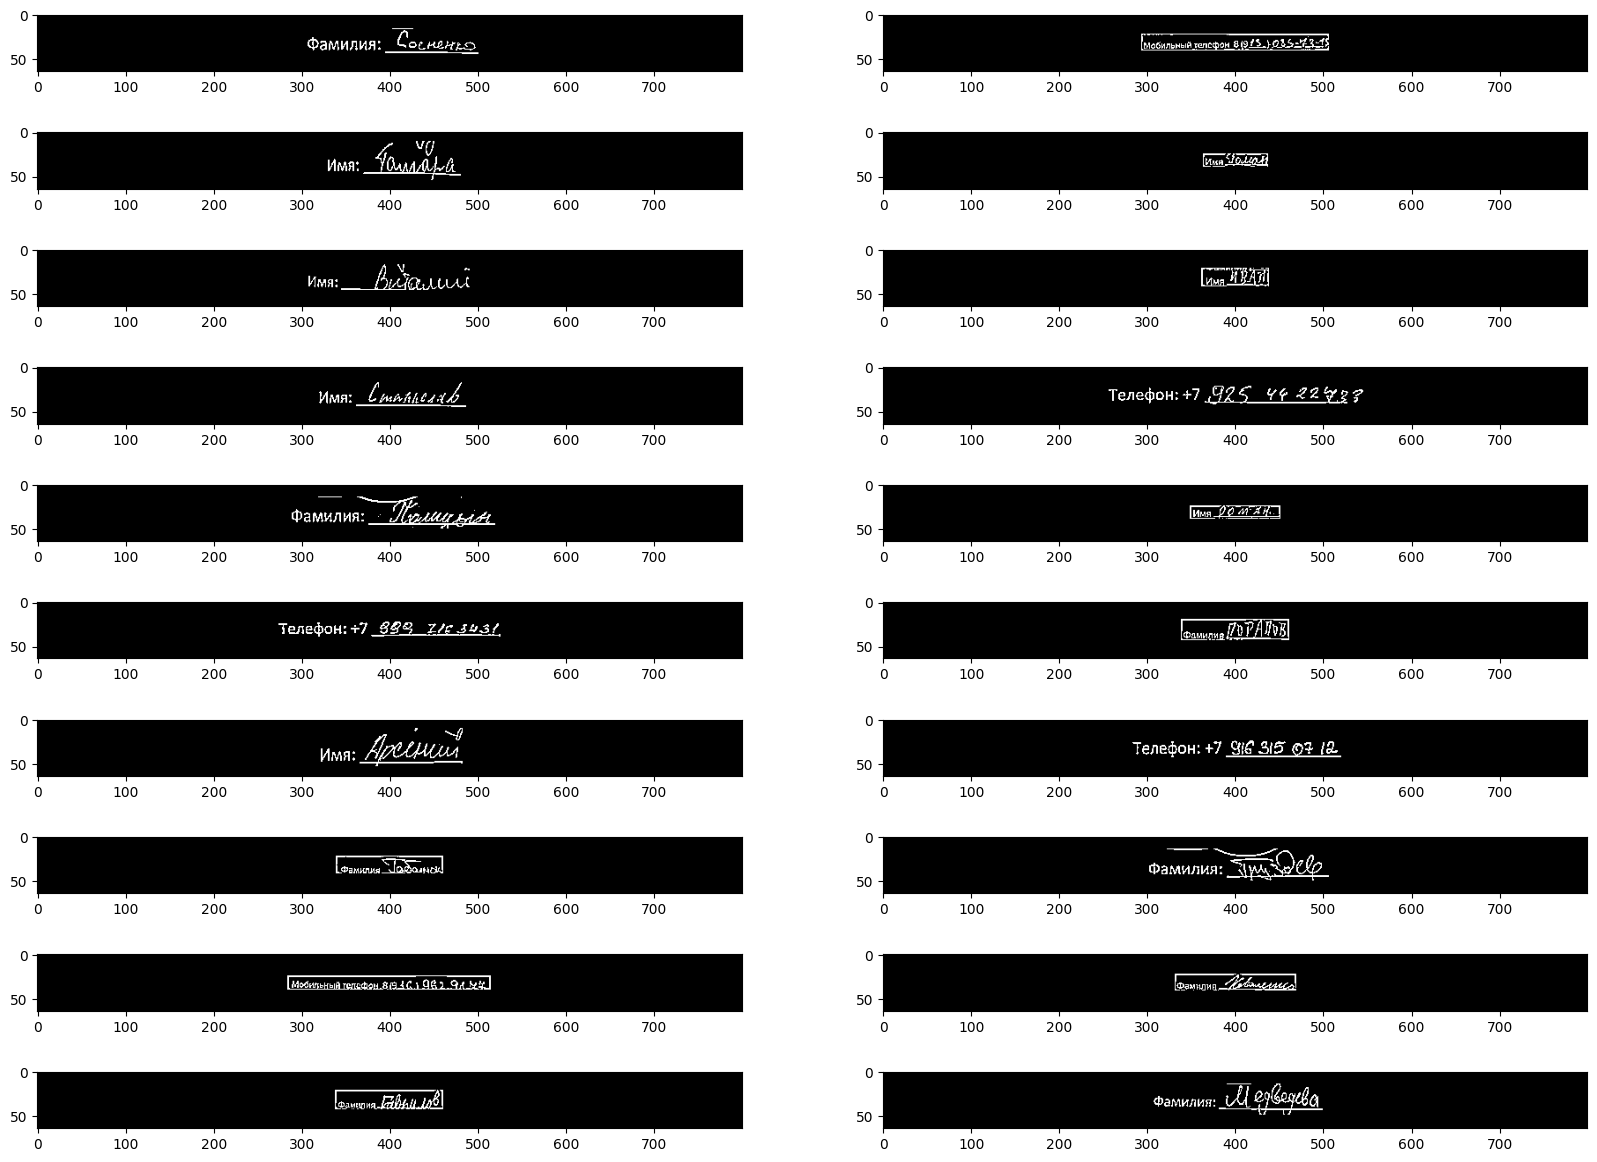

In [ ]:
fig, axes = plt.subplots(figsize=(20, 15), ncols=2, nrows=10)

# Preprocess example

for i in range(10):
  for j in range(2):
    axes[i, j % 2].imshow(cv2.rotate(
        (train_X[i * 2 + j % 2]).astype(np.uint8),cv2.ROTATE_90_COUNTERCLOCKWISE),
        cmap='gray')

## Model

In [ ]:
class CERMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the Character Error Rate
    """
    def __init__(self, name='CER_metric', **kwargs):
        super(CERMetric, self).__init__(name=name, **kwargs)
        self.cer_accumulator = self.add_weight(name="total_cer", initializer="zeros")
        self.counter = self.add_weight(name="cer_count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        input_shape = K.shape(y_pred)
        input_length = tf.ones(shape=input_shape[0]) * K.cast(input_shape[1], 'float32')

        decode, log = K.ctc_decode(y_pred, input_length, greedy=True)

        decode = K.ctc_label_dense_to_sparse(decode[0], K.cast(input_length, 'int32'))
        y_true_sparse = K.ctc_label_dense_to_sparse(y_true, K.cast(input_length, 'int32'))
        y_true_sparse = tf.sparse.retain(y_true_sparse, tf.not_equal(y_true_sparse.values, tf.math.reduce_max(y_true_sparse.values)))

        decode = tf.sparse.retain(decode, tf.not_equal(decode.values, -1))
        distance = tf.edit_distance(decode, y_true_sparse, normalize=True)

        self.cer_accumulator.assign_add(tf.reduce_sum(distance))
        self.counter.assign_add(K.cast(tf.shape(y_true)[0], 'float32'))

    def result(self):
        return tf.math.divide_no_nan(self.cer_accumulator, self.counter)

    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)


def CTCLoss(y_true, y_pred):
    """
    Compute the training-time loss value
    """
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = K.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
model = Sequential()

model.add(Conv2D(64, (5, 5), padding='same', activation=LeakyReLU(alpha=0.01), input_shape=(800, 64, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (5, 5), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((1, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))

model.add(Conv2D(256, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((1, 2)))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((1, 2)))

model.add(Reshape((100, 512)))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(256, return_sequences=True)))

model.add(Dense(len(alphabet) + 1, activation='softmax')) # +1 for ctc blank

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 800, 64, 64)         │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 400, 32, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 400, 32, 128)        │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 400, 16, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 400, 16, 128)        │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 200, 8, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 200, 8, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 200, 8, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 200, 8, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 100, 4, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 100, 4, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 100, 2, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 100, 2, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 100, 2, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 100, 1, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 100, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100, 512)            │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 100, 512)            │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100, 74)             │          37,962 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,969,738 (30.40 MB)

 Trainable params: 7,968,458 (30.40 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [ ]:
model.compile(optimizer=Nadam(learning_rate=0.001, clipnorm=1.0), loss=CTCLoss, metrics=[CERMetric()])

## Train model

In [ ]:
history = model.fit(train_X, train_y, validation_data=(val_X, val_y),
                    epochs=75, batch_size=8,
                    callbacks=[EarlyStopping(patience=10, restore_best_weights=True, monitor='val_CER_metric', mode='min'),
                              ReduceLROnPlateau(factor=0.5, min_lr=1e-5, patience=4, monitor='val_CER_metric', mode='min')],
                    verbose=1)

Epoch 1/75
97/97 ━━━━━━━━━━━━━━━━━━━━ 31s 149ms/step - CER_metric: 0.9886 - loss: 88.0608 - val_CER_metric: 0.8751 - val_loss: 46.2407 - learning_rate: 0.0010
Epoch 2/75
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - CER_metric: 0.7979 - loss: 42.1903 - val_CER_metric: 0.7035 - val_loss: 33.5993 - learning_rate: 0.0010
Epoch 3/75
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - CER_metric: 0.5990 - loss: 31.5115 - val_CER_metric: 0.5667 - val_loss: 30.9338 - learning_rate: 0.0010
Epoch 4/75
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - CER_metric: 0.5328 - loss: 29.1775 - val_CER_metric: 0.5338 - val_loss: 28.1190 - learning_rate: 0.0010
Epoch 5/75
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - CER_metric: 0.5292 - loss: 28.5027 - val_CER_metric: 0.5510 - val_loss: 27.6153 - learning_rate: 0.0010
Epoch 6/75
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - CER_metric: 0.5130 - loss: 26.7140 - val_CER_metric: 0.6204 - val_loss: 31.8928 - learning_rate: 0.0010
Epoch 7/75
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 120m

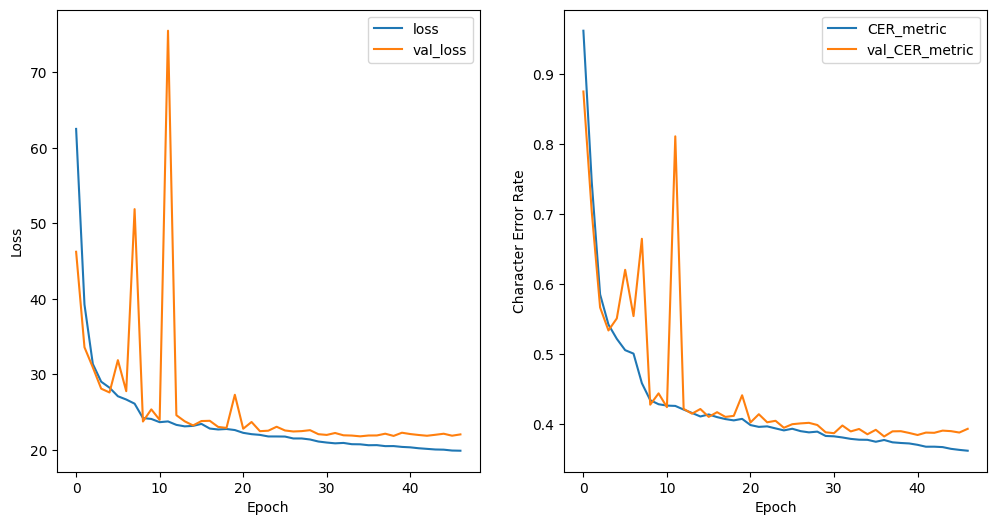

In [ ]:
fig, axes = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)

axes[0].plot(history.history['loss'], label='loss')
axes[0].plot(history.history['val_loss'], label='val_loss')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[1].plot(history.history['CER_metric'], label='CER_metric')
axes[1].plot(history.history['val_CER_metric'], label='val_CER_metric')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Character Error Rate")
axes[1].legend()

plt.show()

In [ ]:
model.save('./crnn.h5')

In [ ]:
# model = load_model('path/to/model', custom_objects={'CTCLoss' : CTCLoss, 'CERMetric': CERMetric})

## Model training results

In [ ]:
# Test results: (loss, cer)

model.evaluate(test_X, test_y)

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - CER_metric: 0.3909 - loss: 22.5659


[22.593299865722656, 0.3910908102989197]

In [ ]:
# Decode label for single image

def num_to_label(num, alphabet):
    text = ""
    for ch in num:
        if ch == len(alphabet): # ctc blank
          break
        else:
          text += alphabet[ch]
    return text


# Decode labels for softmax matrix

def decode_text(nums):
  values = get_value(
      ctc_decode(nums, input_length=np.ones(nums.shape[0])*nums.shape[1],
                 greedy=True)[0][0])

  texts = []
  for i in range(nums.shape[0]):
    value = values[i]
    texts.append(num_to_label(value[value >= 0], alphabet))
  return texts

In [ ]:
predicts = model.predict(test_X)
predicts = decode_text(predicts)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


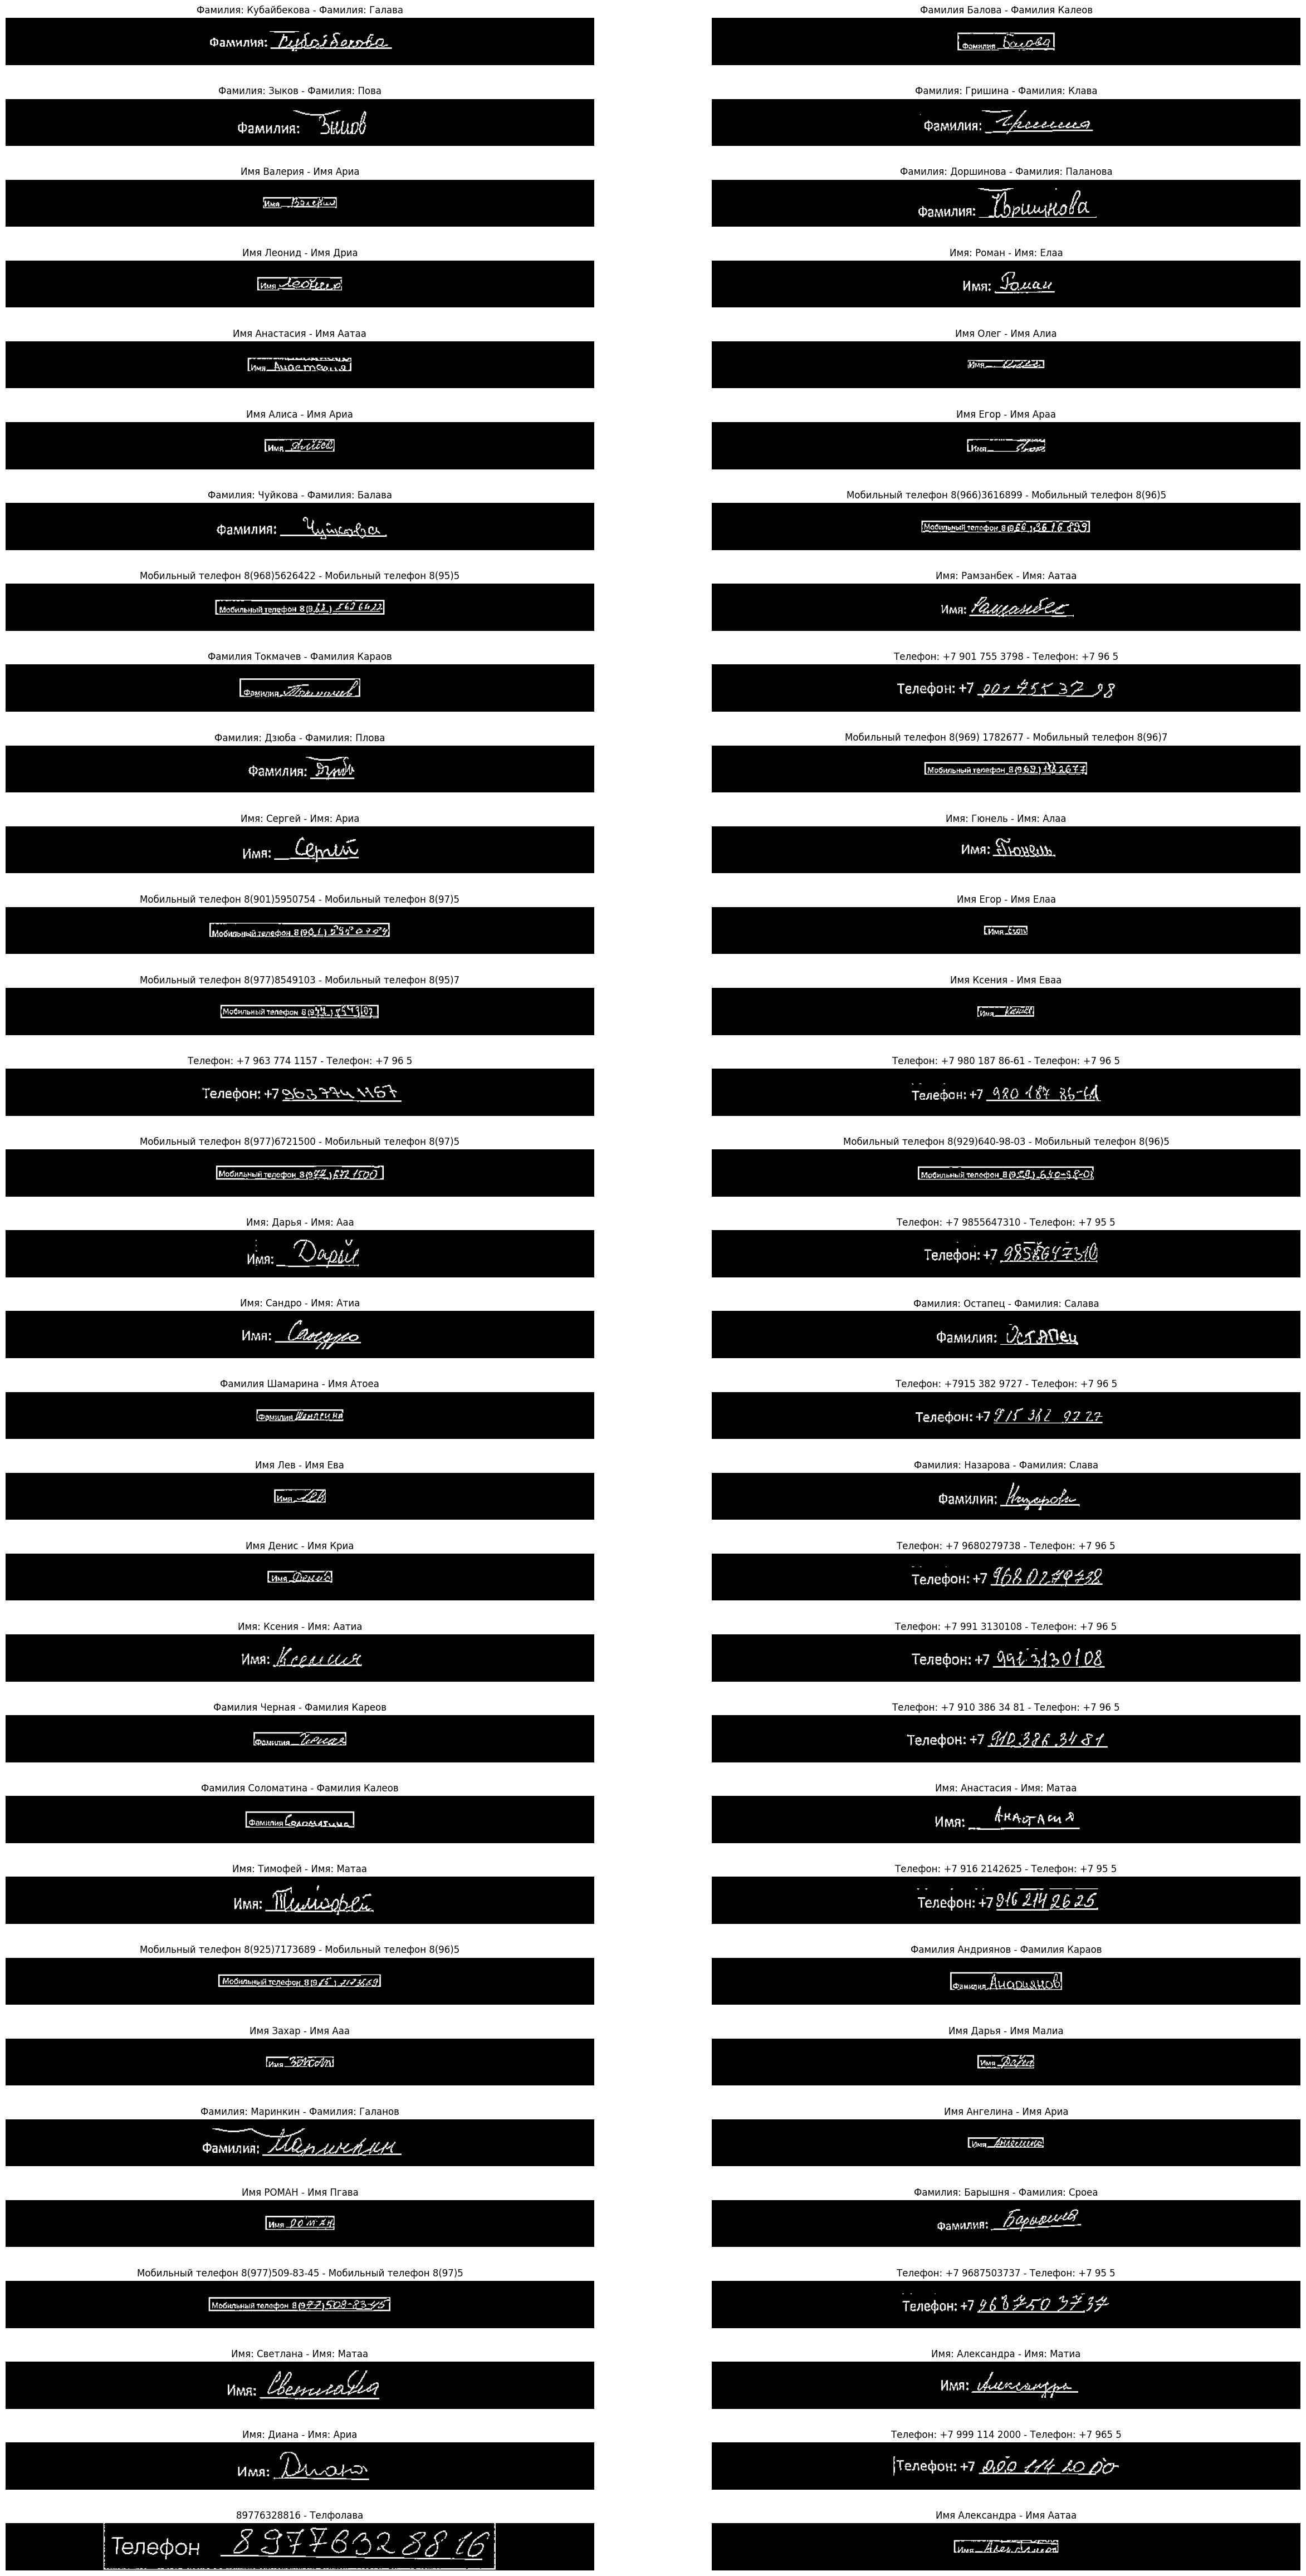

In [ ]:
# Prediction results

fig, axes = plt.subplots(figsize=(30, 60), ncols=2, nrows=32)

test_X = test_X.astype('int')

# Title format: GT - Predict
for i in range(64):
  axes[i // 2, i % 2].imshow(cv2.rotate(
      (test_X[i]).astype(np.uint8),cv2.ROTATE_90_COUNTERCLOCKWISE),
      cmap='gray')
  axes[i // 2, i % 2].set_title(
      f'{num_to_label(test_y[i], alphabet)} - {predicts[i]}')
  axes[i // 2, i % 2].axis("off")

# Эксперемент № 2 300x32

In [ ]:
# Data preprocessing

def preprocess(img):
  for func in [resize_n_rotate, add_adaptiveThreshold]:
    img = func(img)
  return img


def resize_n_rotate(img, shape_to=(32, 300)):
  if img.shape[0] > shape_to[0] or img.shape[1] > shape_to[1]:
    shrink_multiplayer = min(math.floor(shape_to[0] / img.shape[0] * 100) / 100,
                             math.floor(shape_to[1] / img.shape[1] * 100) / 100)
    img = cv2.resize(img, None,
                     fx=shrink_multiplayer,
                     fy=shrink_multiplayer,
                     interpolation=cv2.INTER_AREA)

  img = cv2.copyMakeBorder(img, math.ceil(shape_to[0]/2) - math.ceil(img.shape[0]/2),
                           math.floor(shape_to[0]/2) - math.floor(img.shape[0]/2),
                           math.ceil(shape_to[1]/2) - math.ceil(img.shape[1]/2),
                           math.floor(shape_to[1]/2) - math.floor(img.shape[1]/2),
                           cv2.BORDER_CONSTANT, value=255)
  return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)


def add_adaptiveThreshold(img):
  return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 5, 10).astype('bool')


# Label encoding

def encode_text(texts):
  def _label_to_num(label, alphabet):
    label_num = []
    for ch in label:
      label_num.append(alphabet.find(ch))
    return np.array(label_num)

  alphabet = ''.join(sorted(pd.Series(texts).apply(list).apply(pd.Series).stack().unique()))

  nums = np.ones([len(texts), max([len(text) for text in texts])], dtype='int64') * len(alphabet)
  for i, text in enumerate(texts):
    nums[i][:len(text)] = _label_to_num(text, alphabet)

  return nums, alphabet

In [ ]:
# Load and preprocess data
train_X, train_y = [], []

# Укажите путь к корневой папке с данными
root_folder = '/content/drive/MyDrive/Datasets/fields_m'

# Итерация по папкам 01, 02, 03
for sub_folder in tqdm(os.listdir(root_folder)):
    sub_folder_path = os.path.join(root_folder, sub_folder)  # Получаем путь к подкаталогу

    # Проверяем, что sub_folder_path это действительно папка
    if os.path.isdir(sub_folder_path):
        for image_file in os.listdir(sub_folder_path):
            image_path = os.path.join(sub_folder_path, image_file)  # Полный путь к файлу изображения

            # Извлекаем имя файла без расширения
            file_name_no_ext = image_file[:image_file.rfind('.')]

            # Получаем метку для текущего изображения
            label = gt[gt.fn == file_name_no_ext].value.tolist()[0]

            # Загружаем и предобрабатываем изображение
            image = preprocess(cv2.imread(image_path, 0))

            # Добавляем обработанное изображение и метку в соответствующие списки
            train_X.append(image)
            train_y.append(label)

# Преобразуем списки в массивы
train_X = np.array(train_X)

# Кодируем текстовые метки и получаем алфавит
train_y, alphabet = encode_text(train_y)

# Выводим или возвращаем алфавит
alphabet

100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


' ()+-0123456789:АБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЭЮЯабвгдежзийклмнопрстуфхцчшщыьюя'

In [ ]:
train_X, val_X, train_y, val_y  = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
train_X, test_X, train_y, test_y  = train_test_split(train_X, train_y, test_size=0.25, random_state=42)

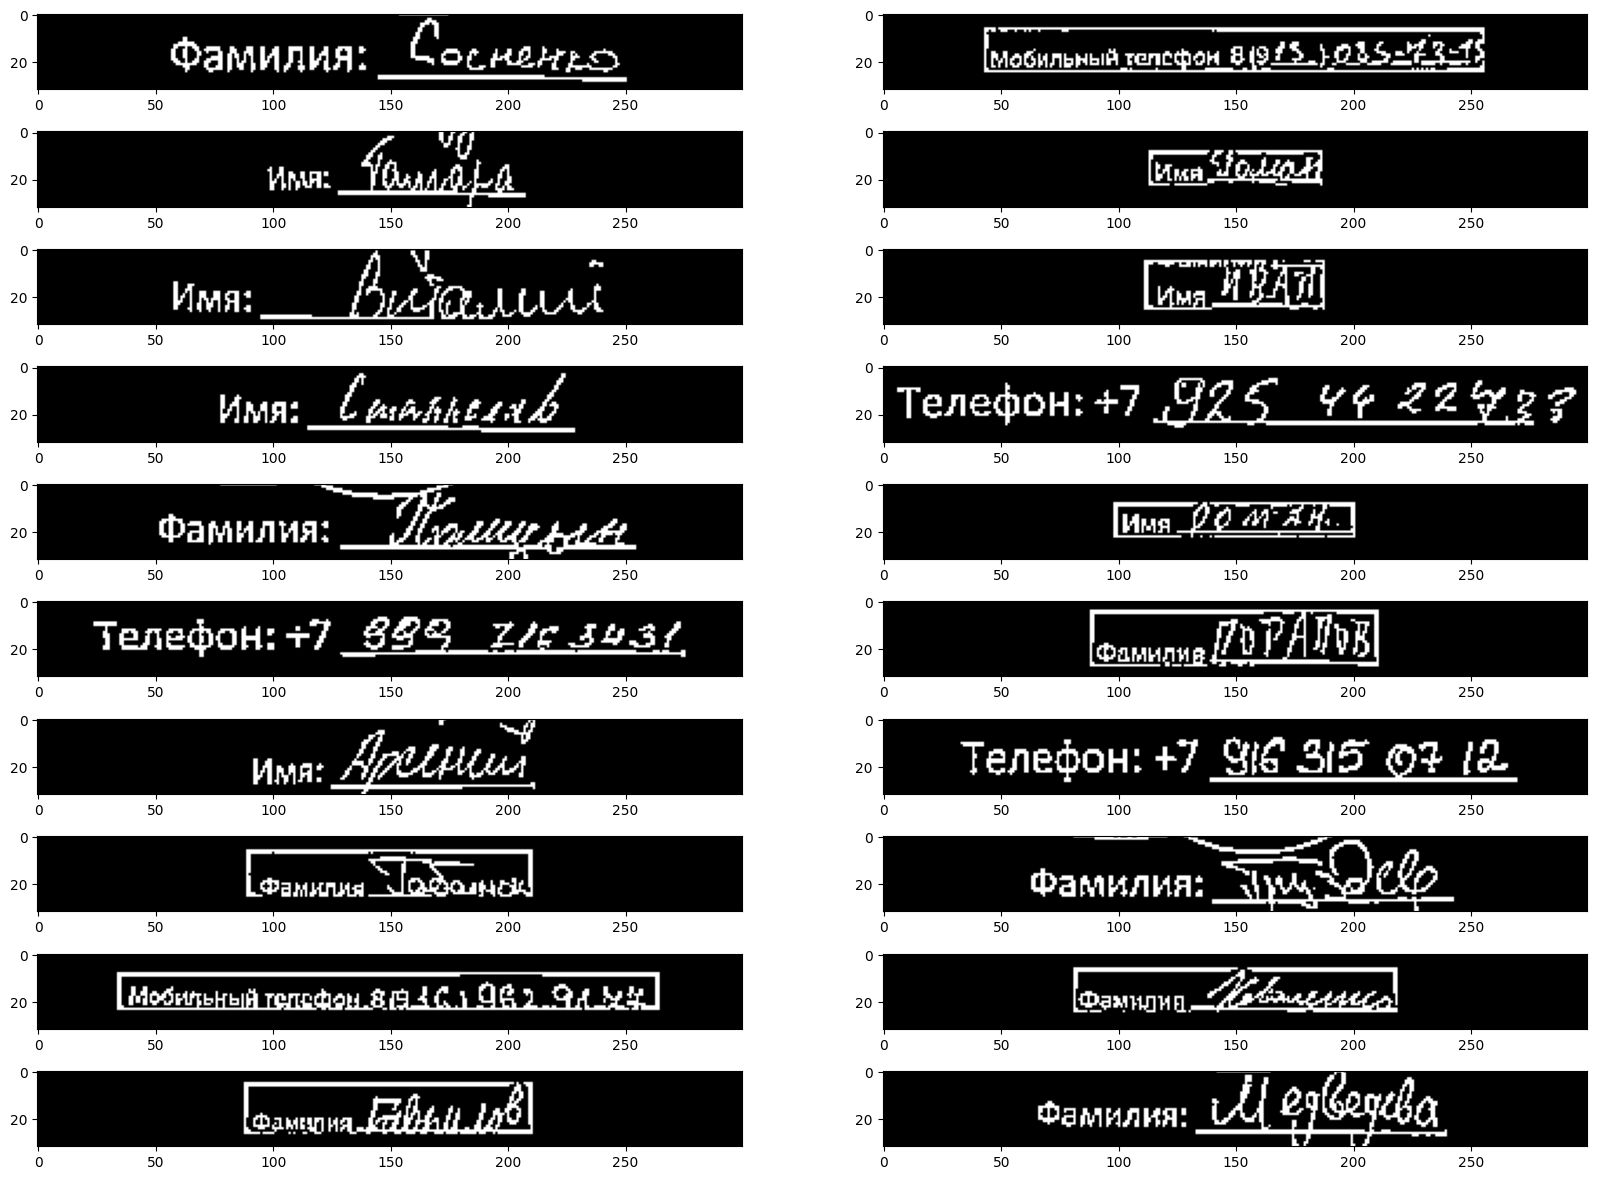

In [ ]:
fig, axes = plt.subplots(figsize=(20, 15), ncols=2, nrows=10)

# Preprocess example

for i in range(10):
  for j in range(2):
    axes[i, j % 2].imshow(cv2.rotate(
        (train_X[i * 2 + j % 2]).astype(np.uint8),cv2.ROTATE_90_COUNTERCLOCKWISE),
        cmap='gray')

In [ ]:
from keras.models import Model

In [ ]:
# Убедитесь, что входные данные соответствуют ожидаемой форме
inputs = Input(shape=(32, 300, 1))

# Слои свертки и пулинга
conv_1 = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(128, (3,3), activation='relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(256, (3,3), activation='relu', padding='same')(pool_2)

conv_4 = Conv2D(256, (3,3), activation='relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(512, (3,3), activation='relu', padding='same')(pool_4)
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(512, (3,3), activation='relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(512, (2,2), activation='relu')(pool_6)

# Изменяем форму, избегая операции squeeze
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

# Слои LSTM
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2))(blstm_1)

# Выходной слой
outputs = Dense(len(alphabet)+1, activation='softmax')(blstm_2)

In [ ]:
# Создание модели
act_model = Model(inputs, outputs)
act_model.compile(optimizer=Nadam(learning_rate=0.001, clipnorm=1.0), loss=CTCLoss, metrics=[CERMetric()])

In [ ]:
# Проверьте модель
act_model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 32, 300, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 32, 300, 64)         │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 16, 150, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 16, 150, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 8, 75, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 8, 75, 256)          │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 8, 75, 256)          │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 4, 75, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 4, 75, 512)          │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 4, 75, 512)          │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 4, 75, 512)          │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 4, 75, 512)          │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 2, 75, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 1, 74, 512)          │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_5 (Lambda)                    │ (None, 74, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 74, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 74, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 74, 74)              │          37,962 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,740,682 (33.34 MB)

 Trainable params: 8,738,634 (33.34 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [ ]:
# Изменение формы train_X
train_X = np.transpose(train_X, (0, 2, 1))
train_X = np.expand_dims(train_X, axis=-1)

# Изменение формы val_X
val_X = np.transpose(val_X, (0, 2, 1))
val_X = np.expand_dims(val_X, axis=-1)

# Изменение формы test_X
test_X = np.transpose(test_X, (0, 2, 1))
test_X = np.expand_dims(test_X, axis=-1)

In [ ]:
# Тренировка модели
history = act_model.fit(train_X, train_y, validation_data=(val_X, val_y),
                        epochs=75, batch_size=32,
                        callbacks=[EarlyStopping(patience=10, restore_best_weights=True, monitor='val_CER_metric', mode='min'),
                                  ReduceLROnPlateau(factor=0.5, min_lr=1e-5, patience=4, monitor='val_CER_metric', mode='min')],
                        verbose=1)

Epoch 1/75
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 253ms/step - CER_metric: 1.0102 - loss: 115.9675 - val_CER_metric: 1.0000 - val_loss: 57.7627 - learning_rate: 0.0010
Epoch 2/75
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - CER_metric: 0.9806 - loss: 51.3740 - val_CER_metric: 0.8915 - val_loss: 53.1815 - learning_rate: 0.0010
Epoch 3/75
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - CER_metric: 0.8123 - loss: 39.1064 - val_CER_metric: 0.7342 - val_loss: 43.9241 - learning_rate: 0.0010
Epoch 4/75
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - CER_metric: 0.6617 - loss: 32.5721 - val_CER_metric: 0.7135 - val_loss: 44.2789 - learning_rate: 0.0010
Epoch 5/75
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - CER_metric: 0.6186 - loss: 29.5188 - val_CER_metric: 0.6619 - val_loss: 35.8439 - learning_rate: 0.0010
Epoch 6/75
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - CER_metric: 0.5879 - loss: 28.5694 - val_CER_metric: 0.6947 - val_loss: 43.4702 - learning_rate: 0.0010
Epoch 7/75
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/ste

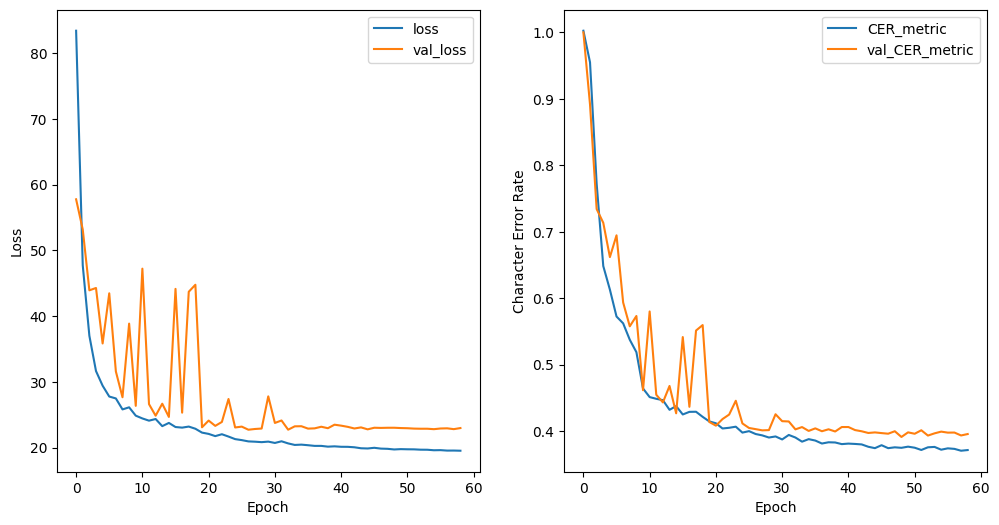

In [ ]:
fig, axes = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)

axes[0].plot(history.history['loss'], label='loss')
axes[0].plot(history.history['val_loss'], label='val_loss')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[1].plot(history.history['CER_metric'], label='CER_metric')
axes[1].plot(history.history['val_CER_metric'], label='val_CER_metric')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Character Error Rate")
axes[1].legend()

plt.show()

In [ ]:
act_model.evaluate(test_X, test_y)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - CER_metric: 0.4039 - loss: 23.7996


[22.91770362854004, 0.39996102452278137]

In [ ]:
# Decode label for single image

def num_to_label(num, alphabet):
    text = ""
    for ch in num:
        if ch == len(alphabet): # ctc blank
          break
        else:
          text += alphabet[ch]
    return text


# Decode labels for softmax matrix

def decode_text(nums):
  values = get_value(
      ctc_decode(nums, input_length=np.ones(nums.shape[0])*nums.shape[1],
                 greedy=True)[0][0])

  texts = []
  for i in range(nums.shape[0]):
    value = values[i]
    texts.append(num_to_label(value[value >= 0], alphabet))
  return texts

In [ ]:
predicts = act_model.predict(test_X)
predicts = decode_text(predicts)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step


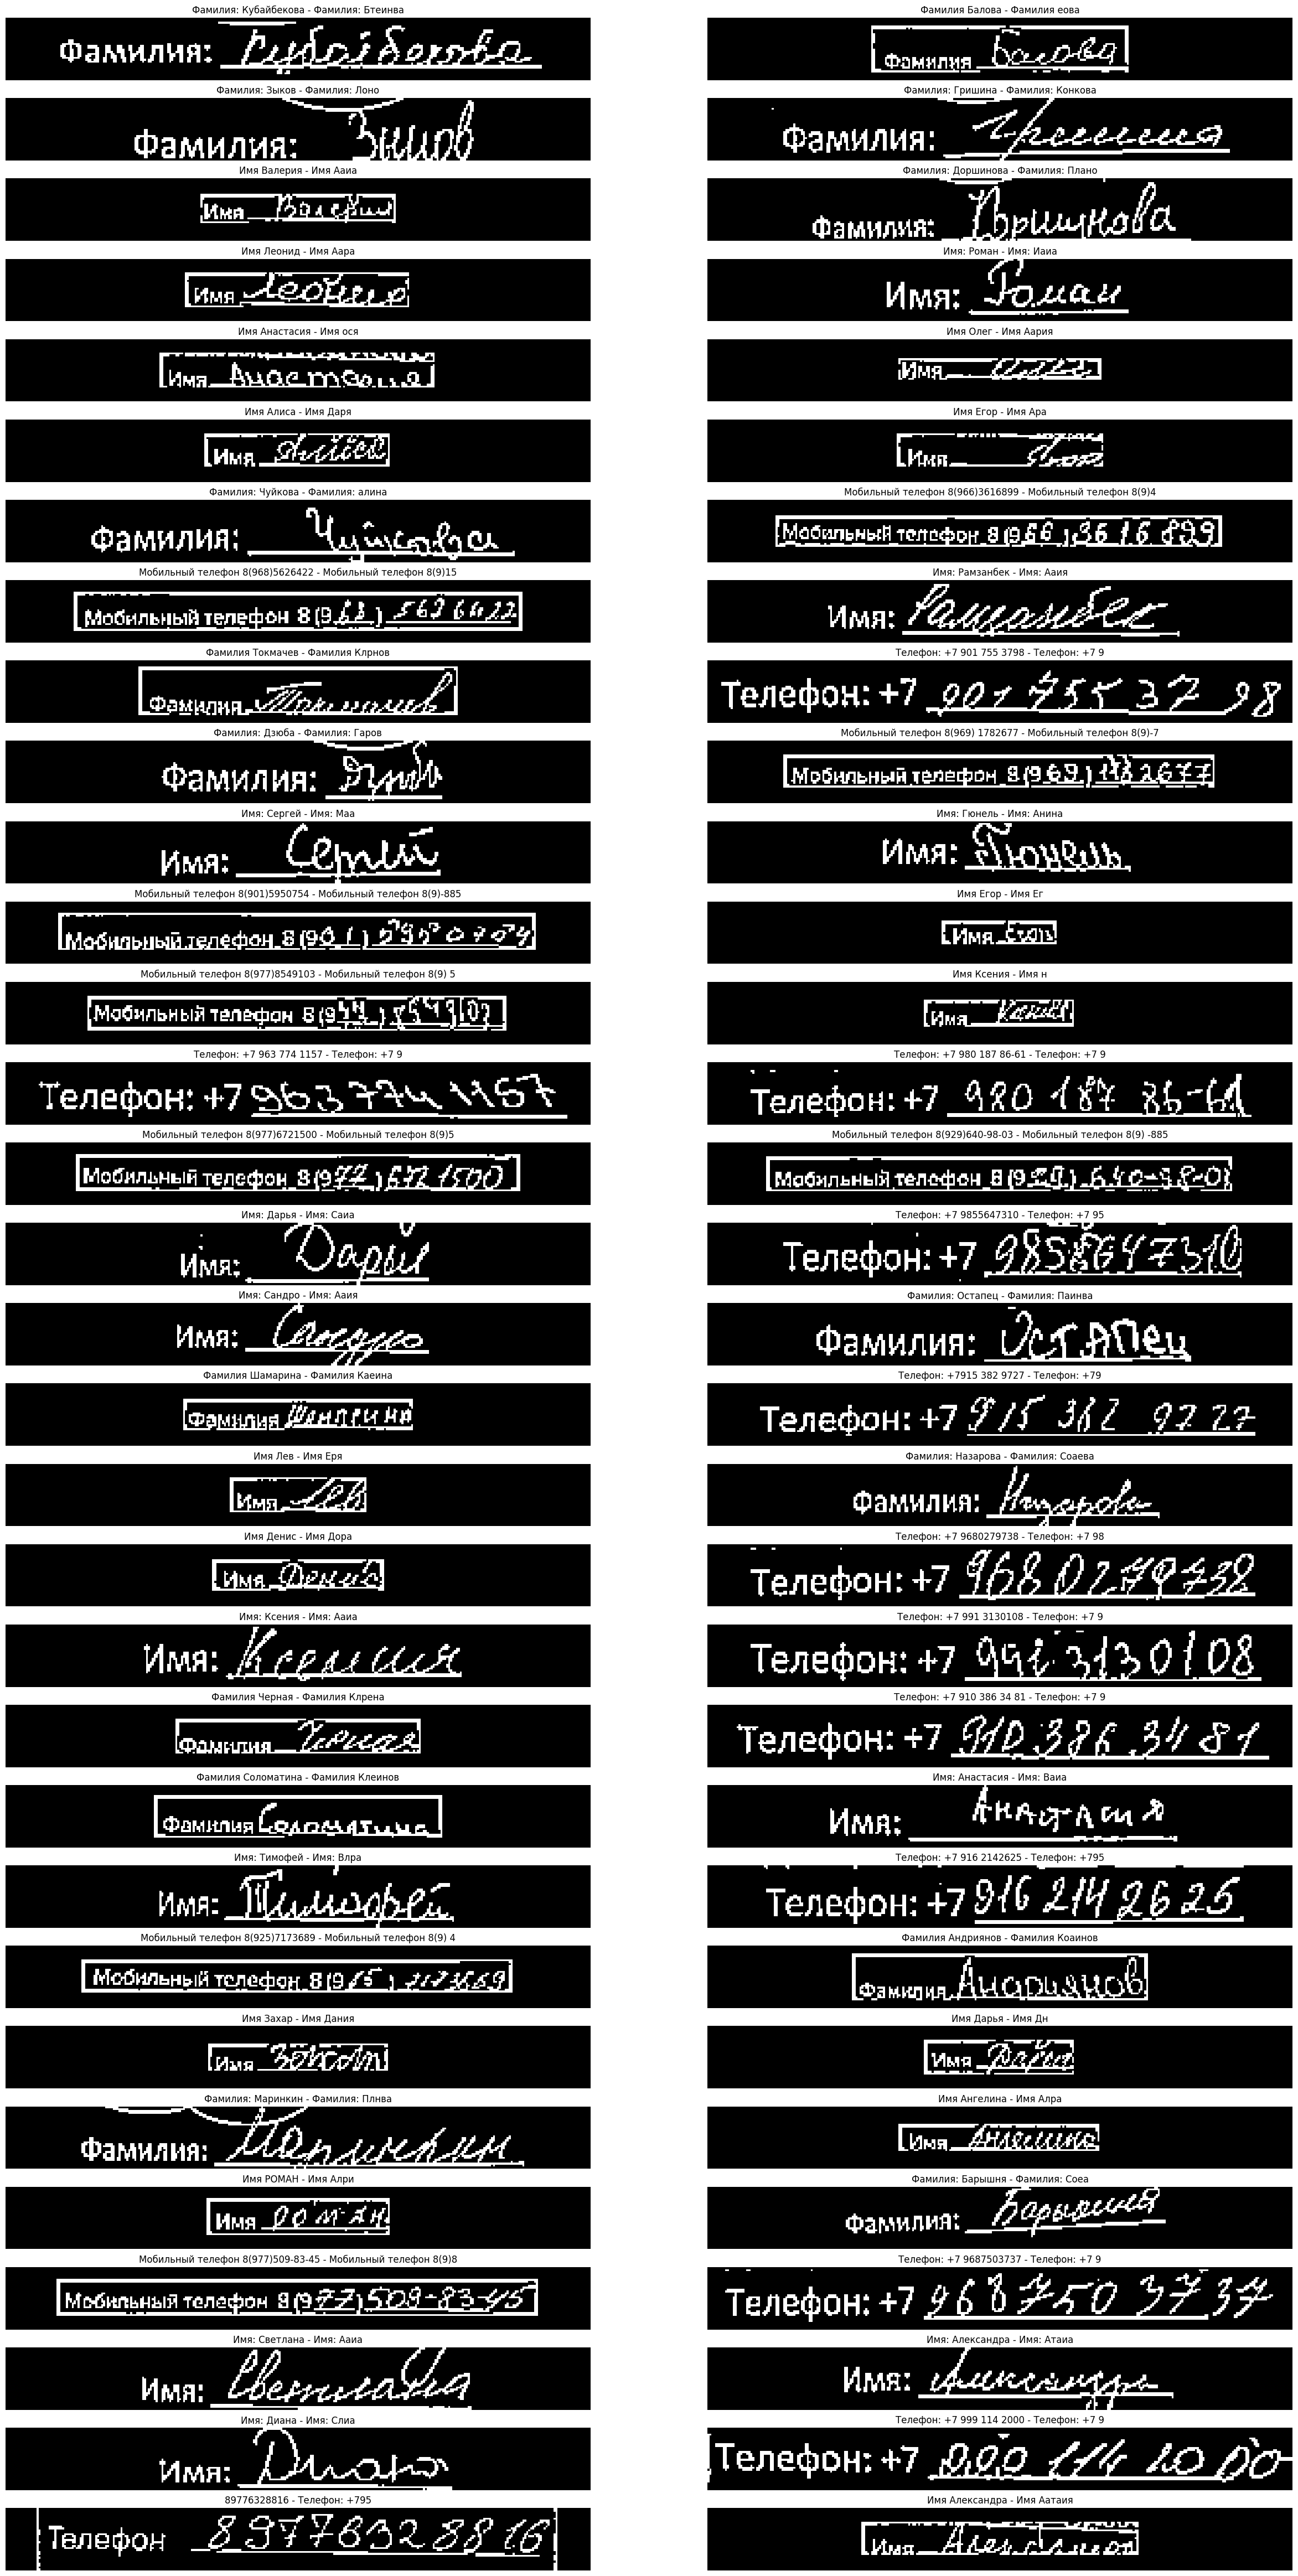

In [ ]:
fig, axes = plt.subplots(figsize=(30, 60), ncols=2, nrows=32)

test_X = test_X.astype('int')

# Title format: GT - Predict
for i in range(64):
    # Rotate the image by 180 degrees to flip it right-side up
    rotated_image = cv2.rotate(test_X[i].astype(np.uint8), cv2.ROTATE_180)

    # Flip the image horizontally around the vertical axis
    flipped_image = cv2.flip(rotated_image, 1)

    axes[i // 2, i % 2].imshow(flipped_image, cmap='gray')
    axes[i // 2, i % 2].set_title(f'{num_to_label(test_y[i], alphabet)} - {predicts[i]}')
    axes[i // 2, i % 2].axis("off")

plt.show()

## Эксперемент №3 GRU

In [ ]:
# Убедитесь, что входные данные соответствуют ожидаемой форме
inputs = Input(shape=(32, 300, 1))

# Слои свертки и пулинга
conv_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool_2)

conv_4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool_4)
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(512, (3, 3), activation='relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(512, (2, 2), activation='relu')(pool_6)

# Изменяем форму, избегая squeeze
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

# Слои GRU вместо LSTM
bgru_1 = Bidirectional(GRU(256, return_sequences=True, dropout=0.2))(squeezed)
bgru_2 = Bidirectional(GRU(256, return_sequences=True, dropout=0.2))(bgru_1)

# Выходной слой
outputs = Dense(len(alphabet) + 1, activation='softmax')(bgru_2)

In [ ]:
# Создание модели
act_model = Model(inputs, outputs)
act_model.compile(optimizer=Nadam(learning_rate=0.001, clipnorm=1.0), loss=CTCLoss, metrics=[CERMetric()])

In [ ]:
# Проверьте модель
act_model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 32, 300, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 32, 300, 64)         │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 16, 150, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 16, 150, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 8, 75, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 8, 75, 256)          │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 8, 75, 256)          │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 4, 75, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 4, 75, 512)          │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 4, 75, 512)          │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 4, 75, 512)          │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 4, 75, 512)          │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 2, 75, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 1, 74, 512)          │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 74, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 74, 512)             │       1,182,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 74, 512)             │       1,182,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 74, 74)              │          37,962 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,956,298 (30.35 MB)

 Trainable params: 7,954,250 (30.34 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [ ]:
# Изменение формы train_X
train_X = np.transpose(train_X, (0, 2, 1))
train_X = np.expand_dims(train_X, axis=-1)

# Изменение формы val_X
val_X = np.transpose(val_X, (0, 2, 1))
val_X = np.expand_dims(val_X, axis=-1)

# Изменение формы test_X
test_X = np.transpose(test_X, (0, 2, 1))
test_X = np.expand_dims(test_X, axis=-1)

In [ ]:
# Тренировка модели
history = act_model.fit(train_X, train_y, validation_data=(val_X, val_y),
                        epochs=75, batch_size=8,
                        callbacks=[EarlyStopping(patience=10, restore_best_weights=True, monitor='val_CER_metric', mode='min'),
                                  ReduceLROnPlateau(factor=0.5, min_lr=1e-5, patience=4, monitor='val_CER_metric', mode='min')],
                        verbose=1)

Epoch 1/75
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - CER_metric: 0.8656 - loss: 86.0118 - val_CER_metric: 0.7739 - val_loss: 48.9114 - learning_rate: 0.0010
Epoch 2/75
97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - CER_metric: 0.6046 - loss: 37.2457 - val_CER_metric: 0.5288 - val_loss: 32.1216 - learning_rate: 0.0010
Epoch 3/75
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - CER_metric: 0.4758 - loss: 29.8019 - val_CER_metric: 0.4747 - val_loss: 31.0600 - learning_rate: 0.0010
Epoch 4/75
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - CER_metric: 0.4636 - loss: 28.0816 - val_CER_metric: 0.4658 - val_loss: 27.8450 - learning_rate: 0.0010
Epoch 5/75
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - CER_metric: 0.4447 - loss: 26.6454 - val_CER_metric: 0.4937 - val_loss: 35.3247 - learning_rate: 0.0010
Epoch 6/75
97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - CER_metric: 0.4359 - loss: 26.1286 - val_CER_metric: 0.4388 - val_loss: 27.0836 - learning_rate: 0.0010
Epoch 7/75
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - CER

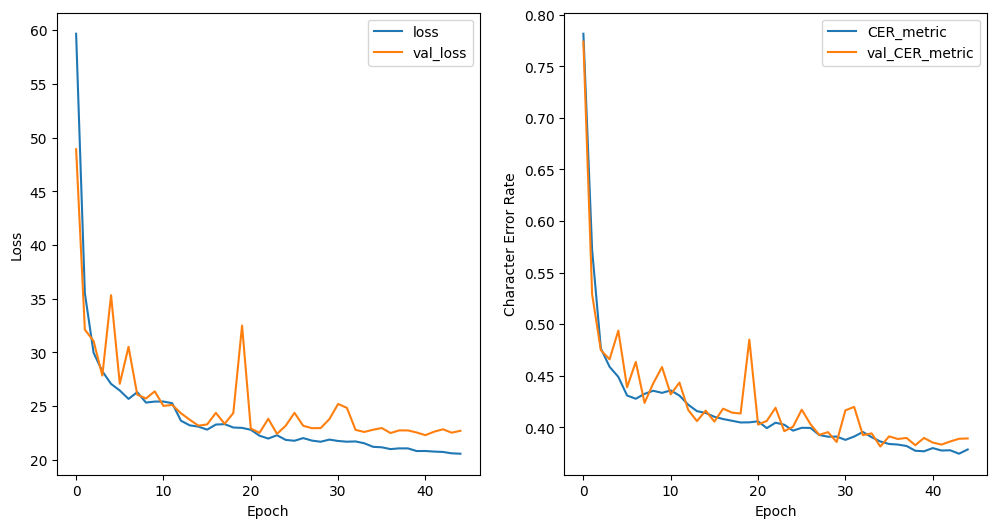

In [ ]:
fig, axes = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)

axes[0].plot(history.history['loss'], label='loss')
axes[0].plot(history.history['val_loss'], label='val_loss')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[1].plot(history.history['CER_metric'], label='CER_metric')
axes[1].plot(history.history['val_CER_metric'], label='val_CER_metric')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Character Error Rate")
axes[1].legend()

plt.show()

In [ ]:
model.save('./crnn_gru.keras')

In [ ]:
act_model.evaluate(test_X, test_y)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - CER_metric: 0.4055 - loss: 25.4268


[24.570499420166016, 0.40071675181388855]

In [ ]:
# Decode label for single image

def num_to_label(num, alphabet):
    text = ""
    for ch in num:
        if ch == len(alphabet): # ctc blank
          break
        else:
          text += alphabet[ch]
    return text


# Decode labels for softmax matrix

def decode_text(nums):
  values = get_value(
      ctc_decode(nums, input_length=np.ones(nums.shape[0])*nums.shape[1],
                 greedy=True)[0][0])

  texts = []
  for i in range(nums.shape[0]):
    value = values[i]
    texts.append(num_to_label(value[value >= 0], alphabet))
  return texts

In [ ]:
predicts = act_model.predict(test_X)
predicts = decode_text(predicts)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step


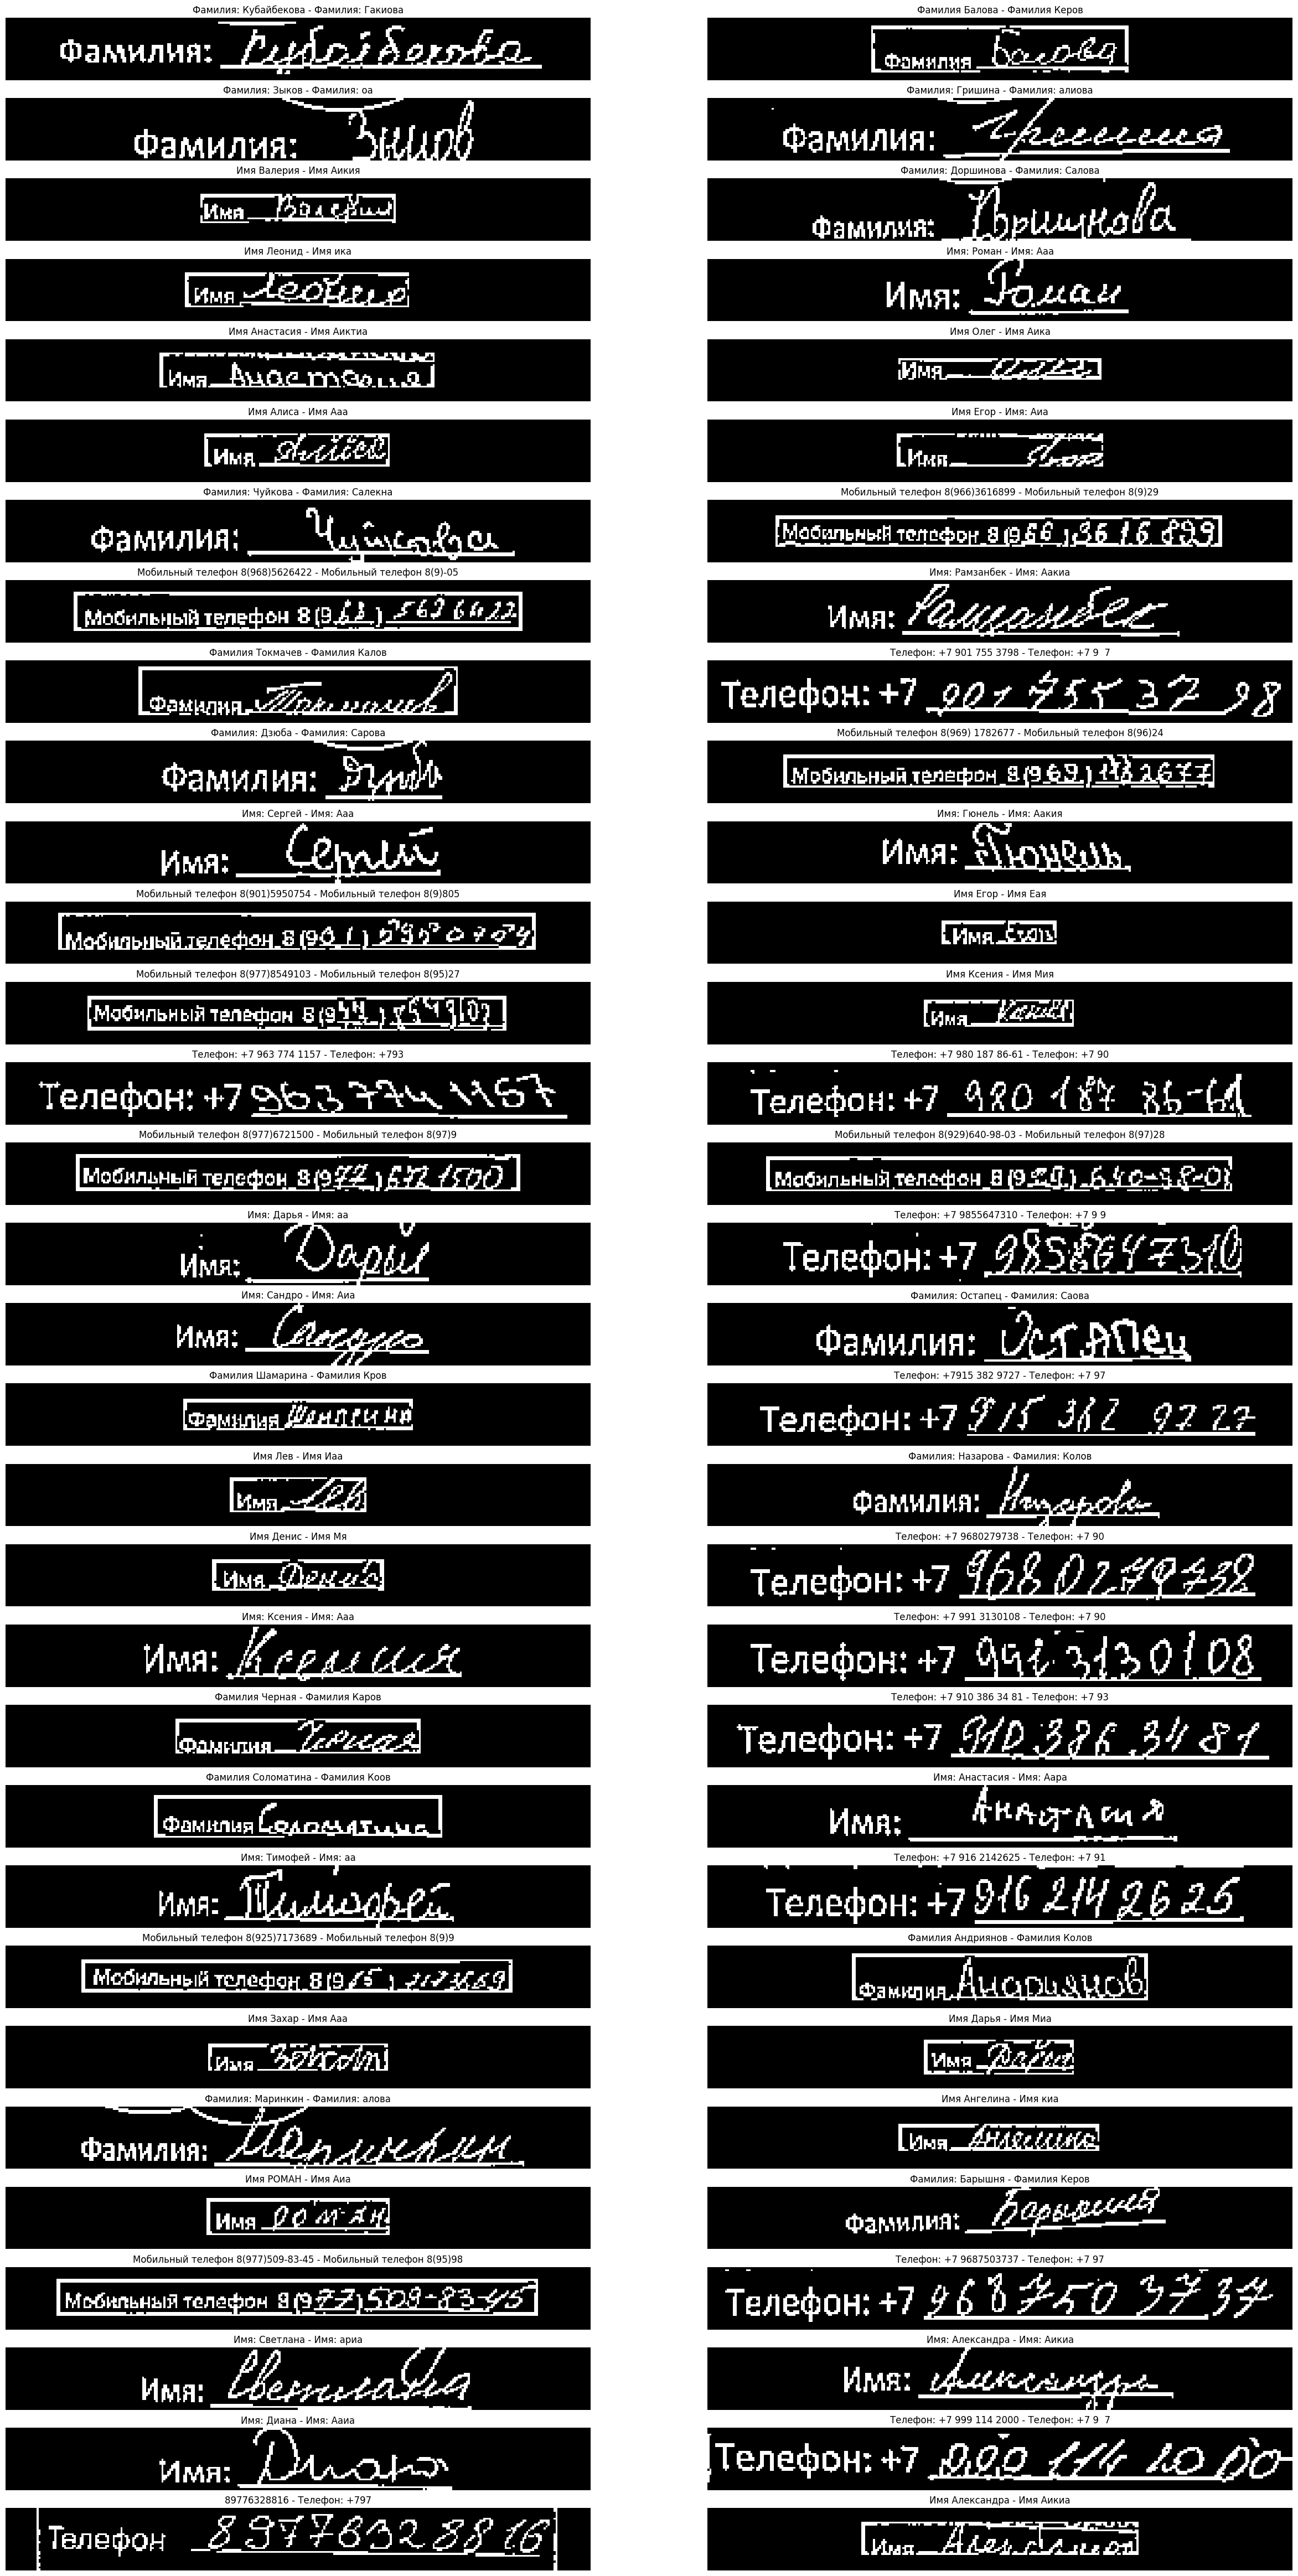

In [ ]:
fig, axes = plt.subplots(figsize=(30, 60), ncols=2, nrows=32)

test_X = test_X.astype('int')

# Title format: GT - Predict
for i in range(64):
    # Rotate the image by 180 degrees to flip it right-side up
    rotated_image = cv2.rotate(test_X[i].astype(np.uint8), cv2.ROTATE_180)

    # Flip the image horizontally around the vertical axis
    flipped_image = cv2.flip(rotated_image, 1)

    axes[i // 2, i % 2].imshow(flipped_image, cmap='gray')
    axes[i // 2, i % 2].set_title(f'{num_to_label(test_y[i], alphabet)} - {predicts[i]}')
    axes[i // 2, i % 2].axis("off")

plt.show()